# Laboratorio 2 - Visión por computadora

- Nelson García
- Joaquín Puente 
- Diego Linares

## Task 3 

Una fábrica textil necesita detectar rasgaduras en telas de mezclilla (denim) automáticamente. El problema
es que la tela tiene una textura natural fuerte (patrón repetitivo) que confunde a los detectores de bordes
simples (Canny), detectando el tejido como si fuera un defecto. Por ello se le pide que usted diseñe un
pipeline híbrido que combine Fourier y Morfología para aislar solamente la rasgadura. Para ello comienza
por probar su solución en una imagen que tiene a mano. Con esto en mente, realice:

In [31]:
# Importar librerías:

import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. Utilice Fourier para analizar la textura repetitiva de la tela. Diseñe un filtro que elimine las
frecuencias altas/repetitivas del tejido, dejando una imagen "suavizada" donde solo resalte la
anomalía (la rasgadura) y la iluminación global. (Supresión de Textura)
a. Hint: ¿Qué pasa si eliminamos las frecuencias altas periféricas o específicas?

In [40]:
IMG_NAME = "imgs/textile_defect.jpg"

In [41]:
LOWPASS_SIGMA = 35       # más alto = más suavizado (menos textura)
NOTCH_PEAKS = 8          # cuántos picos de textura apagar
NOTCH_RADIUS = 10        # tamaño del "agujero" alrededor del pico


In [42]:
# --- Cargar imagen en gris ---
img = cv2.imread(IMG_NAME, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"No pude leer {IMG_NAME}. ¿Está en el mismo folder?")

h, w = img.shape
cy, cx = h // 2, w // 2

In [43]:
# --- FFT (pasar a frecuencia) ---
F = np.fft.fft2(img.astype(np.float32))
Fshift = np.fft.fftshift(F)

In [44]:
print(Fshift)

[[-46818.         +0.j      -15542.334  -14124.787j
   -1315.128   +2560.6072j  ...  16163.516  -12359.44j
   -1315.128   -2560.6072j  -15542.334  +14124.787j  ]
 [-42763.934  +45745.11j    -20754.08   +24393.75j
   27225.318  -28475.424j   ... -29745.432  -27209.166j
  -46741.977  -17339.371j     -308.83356  -997.44867j]
 [  7145.835  -11420.683j    -1509.8965 -15950.877j
   15764.856  +48837.18j    ... -24121.773  +14740.924j
  -23631.668   +8009.361j   -23949.033   -7855.8438j ]
 ...
 [-25969.887   -3371.182j     9763.761  +11495.742j
   19612.19    -2855.056j   ... -37194.16    +3082.2898j
    5075.513  +24110.418j   -58052.992  +10967.885j  ]
 [  7145.835  +11420.683j   -23949.033   +7855.8438j
  -23631.668   -8009.361j   ...  17084.309   +8092.7744j
   15764.856  -48837.18j     -1509.8965 +15950.877j  ]
 [-42763.934  -45745.11j      -308.83356  +997.44867j
  -46741.977  +17339.371j   ... -16692.252  +41374.4j
   27225.318  +28475.424j   -20754.08   -24393.75j   ]]


In [51]:
# Magnitud (para visualizar el espectro y encontrar picos)
mag = np.log1p(np.abs(Fshift))

In [52]:
# --- Filtro 1: Low-pass gaussiano (quita altas frecuencias periféricas) ---
yy, xx = np.mgrid[0:h, 0:w]
dist2 = (yy - cy) ** 2 + (xx - cx) ** 2
lowpass = np.exp(-dist2 / (2.0 * (LOWPASS_SIGMA ** 2))).astype(np.float32)

# --- Filtro 2: Notch (apaga picos fuertes repetitivos del tejido) ---
mag2 = mag.copy()

In [53]:
# Quitar la zona central para no escoger "iluminación global" como pico
center_block = 25
mag2[cy - center_block:cy + center_block, cx - center_block:cx + center_block] = 0


In [54]:
# Elegir los picos más fuertes (aprox. patrones repetitivos)
flat = mag2.ravel()
idxs = np.argpartition(flat, -NOTCH_PEAKS)[-NOTCH_PEAKS:]
coords = np.column_stack(np.unravel_index(idxs, mag2.shape))


In [55]:
notch = np.ones((h, w), dtype=np.float32)
for y, x in coords:
    # Apaga un disco alrededor del pico y su simétrico (porque FFT de imagen real es simétrica)
    cv2.circle(notch, (int(x), int(y)), NOTCH_RADIUS, 0, -1)
    y2, x2 = int(2 * cy - y), int(2 * cx - x)
    if 0 <= y2 < h and 0 <= x2 < w:
        cv2.circle(notch, (x2, y2), NOTCH_RADIUS, 0, -1)

In [56]:
# --- Máscara final en frecuencia ---
freq_mask = lowpass * notch

# --- Aplicar filtro en frecuencia ---
F_filt = Fshift * freq_mask

# --- IFFT (volver al dominio espacial) ---
img_back = np.fft.ifft2(np.fft.ifftshift(F_filt))
img_back = np.real(img_back)

# Normalizar para visualizar bien
smooth = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

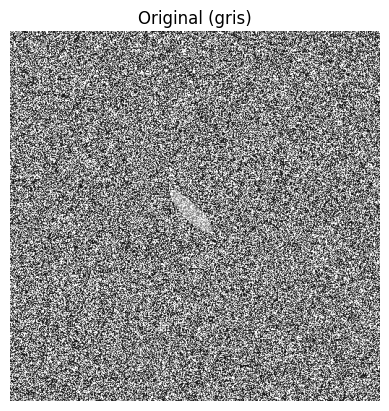

In [58]:
# --- Mostrar etapas ---
plt.figure()
plt.title("Original (gris)")
plt.imshow(img, cmap="gray")
plt.axis("off")



(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

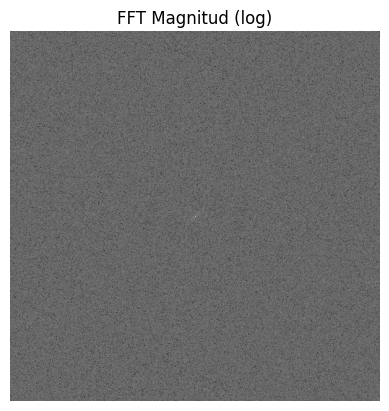

In [59]:
plt.figure()
plt.title("FFT Magnitud (log)")
plt.imshow(mag, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

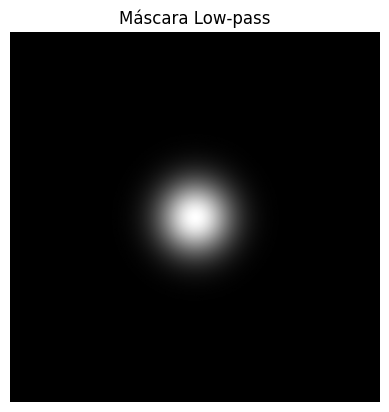

In [60]:
plt.figure()
plt.title("Máscara Low-pass")
plt.imshow(lowpass, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

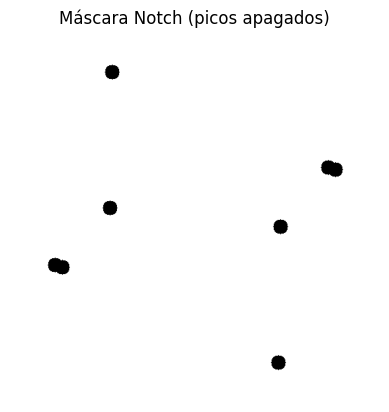

In [61]:
plt.figure()
plt.title("Máscara Notch (picos apagados)")
plt.imshow(notch, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

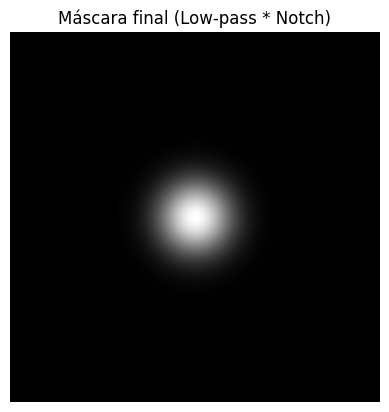

In [62]:
plt.figure()
plt.title("Máscara final (Low-pass * Notch)")
plt.imshow(freq_mask, cmap="gray")
plt.axis("off")


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

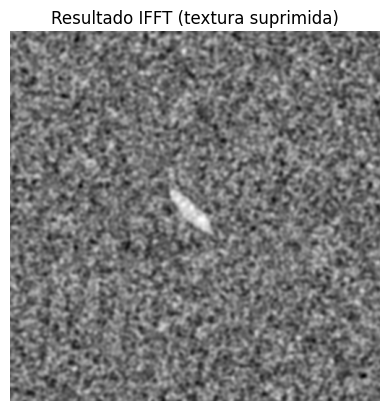

In [63]:
plt.figure()
plt.title("Resultado IFFT (textura suprimida)")
plt.imshow(smooth, cmap="gray")
plt.axis("off")

In [64]:
plt.show()